## Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Getting the data

We scrape the data from Yahoo finance by passing the stock ticker and the start and end time.

In [2]:
stock_ticker = 'AAPL'
start = pd.to_datetime(['2007-01-01']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2022-05-06']).astype(int)[0]//10**9 # convert to unix timestamp.
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + stock_ticker + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
df = pd.read_csv(url)
df.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Open,High,Low,Close,Adj Close,Volume
3858,2022-04-29,161.839996,166.199997,157.250000,157.649994,157.649994,131587100
3859,2022-05-02,156.710007,158.229996,153.270004,157.960007,157.960007,123055300
3860,2022-05-03,158.149994,160.710007,156.320007,159.479996,159.479996,88966500
3861,2022-05-04,159.669998,166.479996,159.259995,166.020004,166.020004,108256500
3862,2022-05-05,163.850006,164.070007,154.949997,156.770004,156.770004,130525275


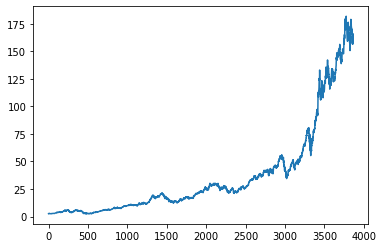

In [3]:
plt.plot(df['Adj Close']) # Plotting the Adjusted closing price 

In [4]:
df = df.drop(['Date', 'Close'], axis = 1)
df.head()

,Open,High,Low,Adj Close,Volume
0,3.081786,3.092143,2.925000,2.562706,1238319600
1,3.001786,3.069643,2.993571,2.619588,847260400
2,3.063214,3.078571,3.014286,2.600933,834741600
3,3.070000,3.090357,3.045714,2.613777,797106800
4,3.087500,3.320714,3.041071,2.830903,3349298400


A moving average (MA) is a widely used technical indicator that smooths out price trends by filtering out the noise from random short-term price fluctuations

In [5]:
ma100 = df['Adj Close'].rolling(100).mean() # 100 days moving average
ma200 = df['Adj Close'].rolling(200).mean() # 200 days moving average

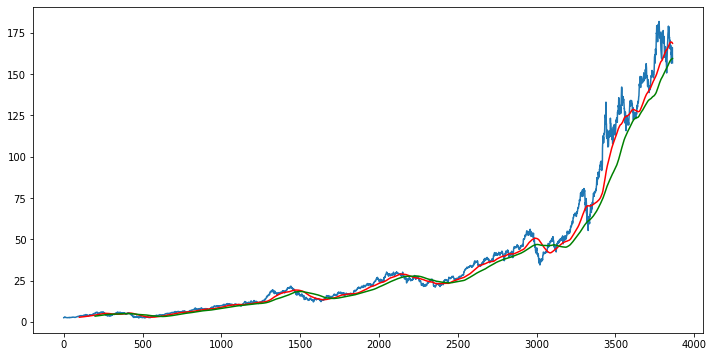

In [6]:
plt.figure(figsize=(12,6))
plt.plot(df['Adj Close'])
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')

## Dividing the data into training and testing sets

In [7]:
data_training = pd.DataFrame(df['Adj Close'][:int(len(df)*0.70)])
data_testing = pd.DataFrame(df['Adj Close'][int(len(df)*0.70):int(len(df))])
data_training.head()

,Adj Close
0,2.562706
1,2.619588
2,2.600933
3,2.613777
4,2.830903


In [8]:
data_training1 = np.array(data_training)
data_training1.shape

(2704, 1)

We will use the Adjusted closing price of the stock of 100 days to predict the Adlusted closing price for the 101st day. Thus, the 100 prices will form the features for the 101st day.

In [9]:
from sklearn.preprocessing import MinMaxScaler
sca = MinMaxScaler(feature_range=(0,1))
data_training1 = sca.fit_transform(data_training1)

In [10]:
x_train = []
y_train = []
for i in range(100, data_training1.shape[0]):
  x_train.append(data_training1[i-100:i])
  y_train.append(data_training1[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]))

In [11]:
x_train.shape

(2604, 100)

In [12]:
past100 = data_training.tail(100)
data_testing = past100.append(data_testing, ignore_index = True)
input_data = np.array(data_testing)

input_data = sca.fit_transform(input_data)
input_data

array([[0.0161859 ],
       [0.01774826],
       [0.01658451],
       ...,
       [0.84939454],
       [0.89356636],
       [0.831091  ]])

In [13]:
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
  x_test.append(input_data[i-100:i])
  y_test.append(input_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))

We will be using a Ensemble Learning model which uses Voting Regressor made up of Linear Regressor, Random Forest Classifier and Support Vector Regressor.

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
r2 = RandomForestRegressor(n_estimators=25, random_state=1)
r3 = SVR()
r4 = XGBRegressor(verbosity=0)
er = VotingRegressor([('xgb', r4), ('rf', r2)])

In [15]:
from sklearn.model_selection import cross_val_score
score_lst = []
r2_scores = cross_val_score(r2, x_train, y_train, scoring="neg_mean_squared_error", cv=10)
r2_rmse_scores = np.sqrt(-r2_scores)
r3_scores = cross_val_score(r3, x_train, y_train, scoring="neg_mean_squared_error", cv=10)
r3_rmse_scores = np.sqrt(-r3_scores)
r4_scores = cross_val_score(r4, x_train, y_train, scoring="neg_mean_squared_error", cv=10)
r4_rmse_scores = np.sqrt(-r4_scores)
er_scores = cross_val_score(er, x_train, y_train, scoring="neg_mean_squared_error", cv=10)
er_rmse_scores = np.sqrt(-er_scores)
def display_scores(scores):
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    score_lst.append(scores.mean())
display_scores(sca.inverse_transform([r2_rmse_scores]))
display_scores(sca.inverse_transform([r3_rmse_scores]))
display_scores(sca.inverse_transform([r4_rmse_scores]))
display_scores(sca.inverse_transform([er_rmse_scores]))

Mean: 38.28714806453803
Standard deviation: 5.431315459817039
Mean: 44.4060544583859
Standard deviation: 10.458910909253788
Mean: 38.54373690204248
Standard deviation: 5.819628017276229
Mean: 38.31862667269733
Standard deviation: 5.650572748756555


In [16]:
from sklearn.metrics import r2_score
r2_pred = r2.fit(x_train, y_train)
r3_pred = r3.fit(x_train, y_train)
r4_pred = r4.fit(x_train, y_train)
er_pred = er.fit(x_train, y_train)
r2_pred = r2.predict(x_train)
r3_pred = r3.predict(x_train)
r4_pred = r4.predict(x_train)
er_pred = er.predict(x_train)
score_r2 = r2_score(r2_pred, y_train)
score_r3 = r2_score(r3_pred, y_train)
score_r4 = r2_score(r4_pred, y_train)
score_er = r2_score(er_pred, y_train)

In [17]:
print('R2 score for Random Forest: ', score_r2)
print('R2 score for Support Vector: ', score_r3)
print('R2 score for Gradient Boost: ', score_r4)
print('R2 score for Voting Regressor: ', score_er)

R2 score for Random Forest:  0.9998529482519347
R2 score for Support Vector:  0.9647277843835973
R2 score for Gradient Boost:  0.9995104841568064
R2 score for Voting Regressor:  0.9997310192438373


[38.28714806453803, 44.4060544583859, 38.54373690204248, 38.31862667269733]


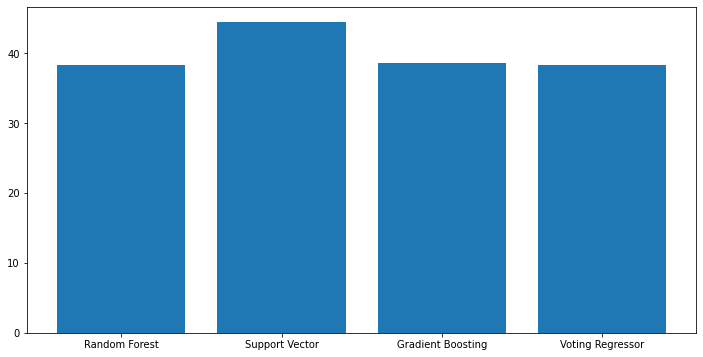

In [18]:
print(score_lst)
x = np.arange(4)
plt.figure(figsize=(12,6))
plt.bar(x, height=score_lst)
plt.xticks(x, ['Random Forest','Support Vector','Gradient Boosting','Voting Regressor']);

Using Grid Search CV we will find the best hyperparameters for the regressors.

In [19]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'rf__n_estimators': [5, 10, 15, 20], 'xgb__n_estimators': [100, 150, 200]},
  {'rf__bootstrap': [False], 'rf__n_estimators': [5, 10, 15, 20], 'xgb__n_estimators': [100, 150, 200]}
]
grid_search = GridSearchCV(er, param_grid, cv = 5, scoring = 'neg_mean_squared_error', return_train_score = True, verbose = 2)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ..........rf__n_estimators=5, xgb__n_estimators=100; total time=   2.0s
[CV] END ..........rf__n_estimators=5, xgb__n_estimators=100; total time=   1.9s
[CV] END ..........rf__n_estimators=5, xgb__n_estimators=100; total time=   1.9s
[CV] END ..........rf__n_estimators=5, xgb__n_estimators=100; total time=   1.9s
[CV] END ..........rf__n_estimators=5, xgb__n_estimators=100; total time=   1.9s
[CV] END ..........rf__n_estimators=5, xgb__n_estimators=150; total time=   2.6s
[CV] END ..........rf__n_estimators=5, xgb__n_estimators=150; total time=   2.7s
[CV] END ..........rf__n_estimators=5, xgb__n_estimators=150; total time=   2.6s
[CV] END ..........rf__n_estimators=5, xgb__n_estimators=150; total time=   2.6s
[CV] END ..........rf__n_estimators=5, xgb__n_estimators=150; total time=   2.5s
[CV] END ..........rf__n_estimators=5, xgb__n_estimators=200; total time=   3.3s
[CV] END ..........rf__n_estimators=5, xgb__n_e

GridSearchCV(cv=5,
             estimator=VotingRegressor(estimators=[('xgb',
                                                    XGBRegressor(verbosity=0)),
                                                   ('rf',
                                                    RandomForestRegressor(n_estimators=25,
                                                                          random_state=1))]),
             param_grid=[{'rf__n_estimators': [5, 10, 15, 20],
                          'xgb__n_estimators': [100, 150, 200]},
                         {'rf__bootstrap': [False],
                          'rf__n_estimators': [5, 10, 15, 20],
                          'xgb__n_estimators': [100, 150, 200]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [20]:
grid_search.best_params_

{'rf__n_estimators': 15, 'xgb__n_estimators': 200}

Using the best estimator to train the data and plot the predictions of the testing data.

In [21]:
er = grid_search.best_estimator_

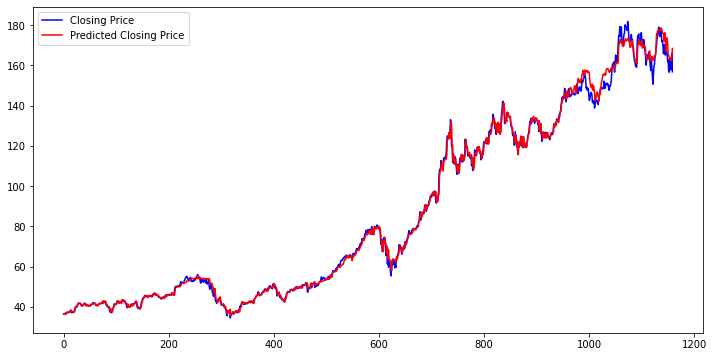

In [22]:
er.fit(x_train, y_train)
y_pred = er.predict(x_test)
plt.figure(figsize=(12,6))
y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)
plt.plot(sca.inverse_transform(y_test), 'b', label='Closing Price')
plt.plot(sca.inverse_transform(y_pred), 'r', label='Predicted Closing Price')
plt.legend()
plt.show()

Predicting the most recent stock value

In [23]:
x1 = data_testing.tail(100)
x1 = sca.fit_transform(x1)
x1 = x1.reshape(1, 100)
y_pred1 = er.predict(x1)

In [24]:
d = np.array([y_pred1])
a = sca.inverse_transform(d)
a[0, 0]

157.38328765859117

Saving the trained model.

In [25]:
import joblib
joblib.dump(er, 'ensemble_model.sav')

['ensemble_model.sav']